# Encrypted Multi-Modal Search

In this tutorial, we introduce how enVector improves the security of Multi-Modal Search.

Recent advances in AI have enabled LLMs and multimodal models to understand user intent and process text, images, audio, and video in an integrated manner.
At the core of this capability are embedding vectors, which numerically represent data and allow semantic similarity comparison across modalities.
Although embeddings provide the expressiveness, they pose security risks because original data can potentially be reconstructed from them.

To address this issue, **enVector** performs **encrypted vector search using fully homomorphic encryption (FHE)**.
enVector ensures strong data privacy and security against various threats while enabling safe and powerful multimodal search in untrusted environments.

## Understanding Multi-Modal Search with enVector

Multi-modal models align embeddings from different modalities, such as text and images, into a shared semantic space.
Each modality is encoded separately, and multi-modal models ensures that they share embedding space, enabling cross-modal understanding and retrieval.
Because all modalities lie in the same space, simple similarity measures like cosine similarity support efficient and scalable multi-modal search.

![Multi-Modal Search Overview](./assets/multi_modal_search.png)

For example, we demonstrate **Text-to-Image Search using enVector**.
Text-to-Image Search retrieves images whose embeddings are most similar to a user’s textual query, and is widely used in applications such as e-commerce and photo search.
With enVector, the query embedding is encrypted and the server performs similarity search directly on encrypted vectors in the index without accessing the query or results in plaintext.
For efficient search, we use an approximate nearest neighbor (ANN) method that scales to large datasets.

In [1]:
import os
import json
import numpy as np
import pyenvector as ev

## Load Dataset

In [ ]:
data_dir = os.environ.get("IMAGE_PATH", "./images")

emb_path = os.path.join(data_dir, "embeddings.npy")
metadata_path = os.path.join(data_dir, "labels.json")
centroid_path: str = os.path.join(data_dir, "centroids.npy")

In [3]:
# get embedding data
embeddings = np.load(emb_path)
embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings = embeddings.astype(np.float32)
print(f"Dataset Shape: {embeddings.shape}")

# get metadata to retrieve
with open(metadata_path, "r") as f:
    metadata = json.load(f)
print(f"Metadata Shape: {len(metadata)}")

assert len(embeddings) == len(metadata), "Embeddings and metadata length mismatch"

Dataset Shape: (1390353, 512)
Metadata Shape: 1390353


In [4]:
# get trained centroids
n_list = 128
centroids = np.load(centroid_path).astype(np.float32)
print(f"Centroids Shape: {centroids.shape} Norm: {np.linalg.norm(centroids, axis=1).mean()}")

Centroids Shape: (128, 512) Norm: 1.0


## enVector Initialization

In [5]:
# es2 initialization
ev.init(
    address="localhost:50050",
    key_path="./keys",
    key_id="tutorial_key",
)

### Index Creation

In [6]:
# configure index parameters
index_params = {
    "index_type": "IVF_FLAT",
    "nlist": 128,
    "default_nprobe": 1,
    "centroids": centroids.tolist()
}

# create index
index = ev.create_index(
    "txt2img_index", 
    dim=512,
    query_encryption="cipher",
    index_params=index_params,
)

In [7]:
# insert data into index
ids = index.insert(embeddings, metadata)

Insert IVF_FLAT: 100%|██████████| 128/128 [08:46<00:00,  4.11s/it]


## Encrypted Similarity Search

### Get Query

In [8]:
query = "My daughter rides a bicycle"

In [ ]:
from typing import Union, List
from fastembed import TextEmbedding

class MultiModalModel:
    def __init__(self):
        self.model = TextEmbedding("Qdrant/clip-ViT-B-32-text")

    def get_text_embedding(self, text: Union[str, List[str]]) -> np.ndarray:
        if isinstance(text, str):
            text = [text]
        text_embedding = list(self.model.embed(text))
        text_embedding = np.squeeze(text_embedding, axis=0)
        return text_embedding

In [13]:
multimodal_model = MultiModalModel()
query_embedding = multimodal_model.get_text_embedding(query)

### Search

In [14]:
results = index.search(query_embedding, top_k=3, output_fields=["metadata"])[0]

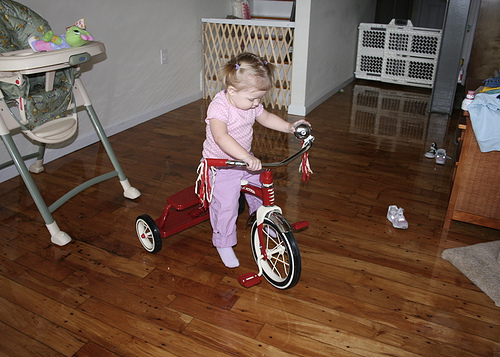

In [15]:
from PIL import Image

top1_res = results[0]
img_path = top1_res["metadata"]["img_path"]

img = Image.open(img_path).convert("RGB")
img

enVector allows for powerful but secure cross-modal retrieval applications including multi-modal search.
Multi-modal models align vectors from different modalities—such as text, images, and audio—into a shared embedding space, enabling semantic search across modalities through simple distance metrics like cosine similarity.
As a result, enVector has become a core component of modern retrieval systems, allowing for flexible, scalable, and modality-agnostic search experiences!